In [1]:
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import apex
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import datetime
import nltk
#nltk.download('words')
words = set(nltk.corpus.words.words())

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc

In [2]:
MAIN_DIR = 'C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/' # Directory where this .ipynb file sits

DATA_PATH = Path(MAIN_DIR + '/bert_data/') # Need to create directory beforehand
DATA_PATH_UP = Path(MAIN_DIR + '/bert_data_up/') # Need to create directory beforehand
DATA_PATH_DOWN = Path(MAIN_DIR + '/bert_data_down/') # Need to create directory beforehand
LABEL_PATH = Path(MAIN_DIR + '/bert_data/') # Need labels.csv (see https://github.com/kaushaltrivedi/fast-bert how to format)

AUG_DATA_PATH = Path(MAIN_DIR + '/bert_models/data_augmentation/') # Need to create directory beforehand
MODEL_PATH=Path(MAIN_DIR + '/bert_models/models/') # Need to create directory beforehand
LOG_PATH=Path(MAIN_DIR + '/bert_models/logs/') # Need to create directory beforehand
MODEL_PATH.mkdir(exist_ok=True)

model_state_dict = None

# BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/cased_L-12_H-768_A-12/')
BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12/')
# BERT_PRETRAINED_PATH = Path('../../bert_fastai/pretrained-weights/uncased_L-24_H-1024_A-16/')
# FINETUNED_PATH = Path('../models/finetuned_model.bin')
FINETUNED_PATH = None
# model_state_dict = torch.load(FINETUNED_PATH)

LOG_PATH.mkdir(exist_ok=True)

OUTPUT_PATH = MODEL_PATH/'output'
OUTPUT_PATH.mkdir(exist_ok=True)

## Transforming Data into format that the model uses

In [3]:
train_data = pd.read_csv(MAIN_DIR + 'profile_data_train.csv')
test_data = pd.read_csv(MAIN_DIR + 'profile_data_test.csv')

In [4]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

train_data = splitDataFrameList(train_data, 'tweets_text', '\t')
test_data = splitDataFrameList(test_data, 'tweets_text', '\t')

In [5]:
df_0 = train_data[train_data.age_group==0]
df_1 = train_data[train_data.age_group==1]
df_2 = train_data[train_data.age_group==2]
df_3 = train_data[train_data.age_group==3]

min_count = min([len(df_0), len(df_1), len(df_2), len(df_3)])

df_0 = resample(df_0, replace=False, n_samples=min_count, random_state=42)
df_1 = resample(df_1, replace=False, n_samples=min_count, random_state=42)
df_2 = resample(df_2, replace=False, n_samples=min_count, random_state=42)
df_3 = resample(df_3, replace=False, n_samples=min_count, random_state=42)
 
train_data_down = pd.concat([df_0, df_1, df_2, df_3])

In [6]:
df_0 = train_data[train_data.age_group==0]
df_1 = train_data[train_data.age_group==1]
df_2 = train_data[train_data.age_group==2]
df_3 = train_data[train_data.age_group==3]

max_count = max([len(df_0), len(df_1), len(df_2), len(df_3)])

df_0 = resample(df_0, replace=True, n_samples=max_count, random_state=42)
df_1 = resample(df_1, replace=True, n_samples=max_count, random_state=42)
df_2 = resample(df_2, replace=True, n_samples=max_count, random_state=42)
df_3 = resample(df_3, replace=True, n_samples=max_count, random_state=42)
 
train_data_up = pd.concat([df_0, df_1, df_2, df_3])

In [7]:
drop_columns = ['handle', 'followers', 'following', 'follower_following_ratio', 'avg_favorites', 'min_favorites', 'max_favorites', 'avg_retweets', 'min_retweets', 'max_retweets', 'hashtags',
                'hashtags_per_tweet', 'mentions_per_tweet', 'avg_timedelta_hrs', 'avg_word_count']

def data_to_bert(data, data_path, split=False):
    if split:
        train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
        
        bert_data_train = pd.concat([train_data,pd.get_dummies(train_data['age_group'], prefix='age_group')],axis=1)
        bert_data_train.drop(['age_group'],axis=1, inplace=True)
        bert_data_train.drop(drop_columns,axis=1, inplace=True)
        bert_data_train.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']
        bert_data_train.to_csv(data_path + '/train.csv', index = False)

        bert_data_val = pd.concat([val_data,pd.get_dummies(val_data['age_group'], prefix='age_group')],axis=1)
        bert_data_val.drop(['age_group'],axis=1, inplace=True)
        bert_data_val.drop(drop_columns,axis=1, inplace=True)
        bert_data_val.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']
        bert_data_val.to_csv(data_path + '/val.csv', index = False)
        
        return train_data, val_data
    else:
        bert_data = pd.concat([data,pd.get_dummies(data['age_group'], prefix='age_group')],axis=1)
        bert_data.drop(['age_group'],axis=1, inplace=True)
        bert_data.drop(drop_columns,axis=1, inplace=True)
        bert_data.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']
        bert_data.to_csv(data_path + '/test.csv', index = False) # Uncomment first time you run
        
        return data

In [8]:
train_data, val_data = data_to_bert(train_data, str(DATA_PATH), split=True)
test_data = data_to_bert(test_data, str(DATA_PATH))

train_data_up, val_data_up = data_to_bert(train_data_up, str(DATA_PATH_UP), split=True)
test_data_up = data_to_bert(test_data, str(DATA_PATH_UP))

train_data_down, val_data_down = data_to_bert(train_data_down, str(DATA_PATH_DOWN), split=True)
test_data_down = data_to_bert(test_data, str(DATA_PATH_DOWN))

In [9]:
torch.cuda.empty_cache()

In [10]:
pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Model Parameters
#### May need to adjust based on your system capabilities
I had to reduce "max_seq_lenth" and "batch_size" because I ran out of memory

In [11]:
args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "toxic_classification_lib",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 128,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 4,
    "eval_batch_size": 8,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": True,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'xlnet-base-cased',
    "model_type": 'xlnet',
    "multi_gpu": False
})

In [12]:
import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

In [13]:
logger.info(args)

05/02/2020 18:14:46 - INFO - root -   {'run_text': 'multilabel toxic comments with freezable layers', 'train_size': -1, 'val_size': -1, 'log_path': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_models/logs'), 'full_data_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_data'), 'data_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_data'), 'task_name': 'intent', 'no_cuda': False, 'bert_model': WindowsPath('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12'), 'output_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_models/models/output'), 'max_seq_length': 128, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 4, 'eval_batch_size': 8, 'learning_rate': 5e-05, 'num_train_epochs': 6, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': True,

In [14]:
# tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_PATH, do_lower_case=args['do_lower_case'])

In [15]:
device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

In [16]:
label_cols = ['age_group_0','age_group_1','age_group_2','age_group_3']

In [17]:
pd.read_csv(str(DATA_PATH) + '/train.csv').shape

(15153, 6)

## Transforming Text to Bert Data

In [18]:
databunch = BertDataBunch(DATA_PATH, LABEL_PATH, args.model_name, train_file='train.csv', val_file='val.csv',
                          test_data='test.csv',
                          text_col="text", label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], max_seq_length=args['max_seq_length'], 
                          multi_gpu=args.multi_gpu, multi_label=True, model_type=args.model_type)

05/02/2020 18:14:46 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
05/02/2020 18:14:46 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,

In [19]:
databunch_up = BertDataBunch(DATA_PATH_UP, LABEL_PATH, args.model_name, train_file='train.csv', val_file='val.csv',
                          test_data='test.csv',
                          text_col="text", label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], max_seq_length=args['max_seq_length'], 
                          multi_gpu=args.multi_gpu, multi_label=True, model_type=args.model_type)

05/02/2020 18:14:57 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
05/02/2020 18:14:57 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,

In [20]:
databunch_down = BertDataBunch(DATA_PATH_DOWN, LABEL_PATH, args.model_name, train_file='train.csv', val_file='val.csv',
                          test_data='test.csv',
                          text_col="text", label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], max_seq_length=args['max_seq_length'], 
                          multi_gpu=args.multi_gpu, multi_label=True, model_type=args.model_type)

05/02/2020 18:15:10 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
05/02/2020 18:15:10 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,

In [21]:
num_labels = len(databunch.labels)
num_labels

4

In [22]:
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'fbeta', 'function': fbeta})

## Defining the Learner

In [23]:
learner = BertLearner.from_pretrained_model(databunch, args.model_name, metrics=metrics, 
                                            device=device, logger=logger, output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, warmup_steps=args.warmup_steps,
                                            multi_gpu=False, is_fp16=args.fp16, 
                                            multi_label=True, logging_steps=0)

05/02/2020 18:15:16 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
05/02/2020 18:15:16 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "_num_labels": 4,
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "mem_len": 

In [24]:
learner_up = BertLearner.from_pretrained_model(databunch_up, args.model_name, metrics=metrics, 
                                            device=device, logger=logger, output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, warmup_steps=args.warmup_steps,
                                            multi_gpu=False, is_fp16=args.fp16, 
                                            multi_label=True, logging_steps=0)

05/02/2020 18:15:20 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
05/02/2020 18:15:20 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "_num_labels": 4,
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "mem_len": 

In [25]:
learner_down = BertLearner.from_pretrained_model(databunch_down, args.model_name, metrics=metrics, 
                                            device=device, logger=logger, output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, warmup_steps=args.warmup_steps,
                                            multi_gpu=False, is_fp16=args.fp16, 
                                            multi_label=True, logging_steps=0)

05/02/2020 18:15:22 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
05/02/2020 18:15:22 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "_num_labels": 4,
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "mem_len": 

## Fitting the Model

In [26]:
learner.fit(1, args.learning_rate, validate=True)
learner.validate()
learner.save_model()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
05/02/2020 18:15:24 - INFO - root -   ***** Running training *****
05/02/2020 18:15:24 - INFO - root -     Num examples = 15153
05/02/2020 18:15:24 - INFO - root -     Num Epochs = 1
05/02/2020 18:15:24 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 4
05/02/2020 18:15:24 -

..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
05/02/2020 18:35:08 - INFO - root -   Running evaluation
05/02/2020 18:35:08 - INFO - root -     Num examples = 1684
05/02/2020 18:35:08 - INFO - root -     Batch size = 8


05/02/2020 18:35:19 - INFO - root -   eval_loss after epoch 1: 0.5055296598311284: 
05/02/2020 18:35:19 - INFO - root -   eval_accuracy_thresh after epoch 1: 0.7649940848350525: 
05/02/2020 18:35:19 - INFO - root -   eval_roc_auc after epoch 1: 0.7163069398916353: 
05/02/2020 18:35:19 - INFO - root -   eval_fbeta after epoch 1: 0.49899619817733765: 
05/02/2020 18:35:19 - INFO - root -   lr after epoch 1: 0.0
05/02/2020 18:35:19 - INFO - root -   train_loss after epoch 1: 0.5236783985586335
05/02/2020 18:35:19 - INFO - root -   



c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


05/02/2020 18:35:19 - INFO - root -   Running evaluation
05/02/2020 18:35:19 - INFO - root -     Num examples = 1684
05/02/2020 18:35:19 - INFO - root -     Batch size = 8


05/02/2020 18:35:31 - INFO - transformers.configuration_utils -   Configuration saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\config.json
05/02/2020 18:35:32 - INFO - transformers.modeling_utils -   Model weights saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\pytorch_model.bin


In [27]:
learner_up.fit(1, args.learning_rate, validate=True)
learner_up.validate()
learner_up.save_model()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
05/02/2020 18:35:32 - INFO - root -   ***** Running training *****
05/02/2020 18:35:32 - INFO - root -     Num examples = 18036
05/02/2020 18:35:32 - INFO - root -     Num Epochs = 1
05/02/2020 18:35:32 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 4
05/02/2020 18:35:32 -

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
05/02/2020 19:00:09 - INFO - root -   Running evaluation
05/02/2020 19:00:09 - INFO - root -     Num examples = 2004
05/02/2020 19:00:09 - INFO - root -     Batch size = 8


05/02/2020 19:00:23 - INFO - root -   eval_loss after epoch 1: 0.4955804996281506: 
05/02/2020 19:00:23 - INFO - root -   eval_accuracy_thresh after epoch 1: 0.771332323551178: 
05/02/2020 19:00:23 - INFO - root -   eval_roc_auc after epoch 1: 0.7180339503959479: 
05/02/2020 19:00:23 - INFO - root -   eval_fbeta after epoch 1: 0.44192567467689514: 
05/02/2020 19:00:23 - INFO - root -   lr after epoch 1: 0.0
05/02/2020 19:00:23 - INFO - root -   train_loss after epoch 1: 0.5299701907499108
05/02/2020 19:00:23 - INFO - root -   

05/02/2020 19:00:23 - INFO - root -   Running evaluation
05/02/2020 19:00:23 - INFO - root -     Num examples = 2004
05/02/2020 19:00:23 - INFO - root -     Batch size = 8


05/02/2020 19:00:37 - INFO - transformers.configuration_utils -   Configuration saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\config.json
05/02/2020 19:00:38 - INFO - transformers.modeling_utils -   Model weights saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\pytorch_model.bin


In [28]:
learner_down.fit(1, args.learning_rate, validate=True)
learner_down.validate()
learner_down.save_model()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
05/02/2020 19:00:38 - INFO - root -   ***** Running training *****
05/02/2020 19:00:38 - INFO - root -     Num examples = 8694
05/02/2020 19:00:38 - INFO - root -     Num Epochs = 1
05/02/2020 19:00:38 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 4
05/02/2020 19:00:38 - 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
05/02/2020 19:12:51 - INFO - root -   Running evaluation
05/02/2020 19:12:51 - INFO - root -     Num examples = 966
05/02/2020 19:12:51 - INFO - root -     Batch size = 8


05/02/2020 19:12:58 - INFO - root -   eval_loss after epoch 1: 0.5258785730058496: 
05/02/2020 19:12:58 - INFO - root -   eval_accuracy_thresh after epoch 1: 0.7616459727287292: 
05/02/2020 19:12:58 - INFO - root -   eval_roc_auc after epoch 1: 0.6715968891232191: 
05/02/2020 19:12:58 - INFO - root -   eval_fbeta after epoch 1: 0.3975648581981659: 
05/02/2020 19:12:58 - INFO - root -   lr after epoch 1: 0.0
05/02/2020 19:12:58 - INFO - root -   train_loss after epoch 1: 0.5578288889413814
05/02/2020 19:12:58 - INFO - root -   

05/02/2020 19:12:58 - INFO - root -   Running evaluation
05/02/2020 19:12:58 - INFO - root -     Num examples = 966
05/02/2020 19:12:58 - INFO - root -     Batch size = 8


05/02/2020 19:13:05 - INFO - transformers.configuration_utils -   Configuration saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\config.json
05/02/2020 19:13:05 - INFO - transformers.modeling_utils -   Model weights saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\pytorch_model.bin


## Predicting the Test Set

In [29]:
predictions = learner.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/test.csv')['text'].values))
predictions_up = learner_up.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/test.csv')['text'].values))
predictions_down = learner_down.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/test.csv')['text'].values))

05/02/2020 19:13:05 - INFO - root -   Writing example 0 of 4263
05/02/2020 19:13:49 - INFO - root -   Writing example 0 of 4263
05/02/2020 19:14:32 - INFO - root -   Writing example 0 of 4263


#### Arg maxing for prediction label
predictions sort based on which category gave the highest prediction

In [30]:
label_pred = []
label_pred_up = []
label_pred_down = []
for pred in predictions:
    if pred[0][0] == 'age_group_0':
        label_pred.append(0)
    elif pred[0][0] == 'age_group_1':
        label_pred.append(1)
    elif pred[0][0] == 'age_group_2':
        label_pred.append(2)
    elif pred[0][0] == 'age_group_3':
        label_pred.append(3)
        
for pred in predictions_up:
    if pred[0][0] == 'age_group_0':
        label_pred_up.append(0)
    elif pred[0][0] == 'age_group_1':
        label_pred_up.append(1)
    elif pred[0][0] == 'age_group_2':
        label_pred_up.append(2)
    elif pred[0][0] == 'age_group_3':
        label_pred_up.append(3)
        
for pred in predictions_down:
    if pred[0][0] == 'age_group_0':
        label_pred_down.append(0)
    elif pred[0][0] == 'age_group_1':
        label_pred_down.append(1)
    elif pred[0][0] == 'age_group_2':
        label_pred_down.append(2)
    elif pred[0][0] == 'age_group_3':
        label_pred_down.append(3)

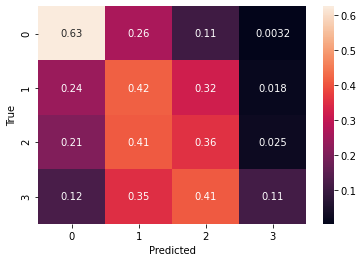

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(test_data['age_group'], label_pred, normalize='true')

0.42059582453671124

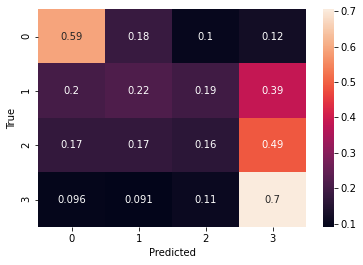

In [33]:
cm = confusion_matrix(test_data['age_group'], label_pred_up, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [34]:
accuracy_score(test_data['age_group'], label_pred_up, normalize='true')

0.3793103448275862

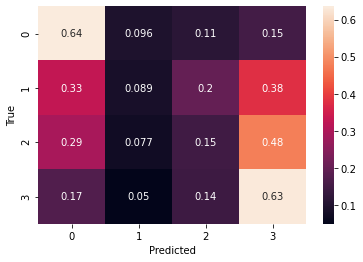

In [35]:
cm = confusion_matrix(test_data['age_group'], label_pred_down, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [36]:
accuracy_score(test_data['age_group'], label_pred_down, normalize='true')

0.34107436077879427

## Metadata Model

In [37]:
import xgboost as xgb

In [38]:
train_data_meta = train_data.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)
val_data_meta = val_data.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)

train_data_meta_up = train_data_up.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)
val_data_meta_up = val_data_up.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)

train_data_meta_down = train_data_down.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)
val_data_meta_down = val_data_down.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)

In [39]:
meta_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
meta_model.fit(train_data_meta.drop('age_group', axis=1), train_data_meta['age_group'], eval_set=[(val_data_meta.drop('age_group', axis=1), val_data_meta['age_group'])], early_stopping_rounds=3)

[0]	validation_0-merror:0.36758
Will train until validation_0-merror hasn't improved in 3 rounds.
[1]	validation_0-merror:0.30760
[2]	validation_0-merror:0.28504
[3]	validation_0-merror:0.26188
[4]	validation_0-merror:0.24525
[5]	validation_0-merror:0.21971
[6]	validation_0-merror:0.20012
[7]	validation_0-merror:0.18587
[8]	validation_0-merror:0.18290
[9]	validation_0-merror:0.16983
[10]	validation_0-merror:0.15974
[11]	validation_0-merror:0.14964
[12]	validation_0-merror:0.14252
[13]	validation_0-merror:0.13717
[14]	validation_0-merror:0.13183
[15]	validation_0-merror:0.12055
[16]	validation_0-merror:0.11520
[17]	validation_0-merror:0.10451
[18]	validation_0-merror:0.09917
[19]	validation_0-merror:0.08729
[20]	validation_0-merror:0.08017
[21]	validation_0-merror:0.08017
[22]	validation_0-merror:0.07838
[23]	validation_0-merror:0.07720
[24]	validation_0-merror:0.06354
[25]	validation_0-merror:0.06473
[26]	validation_0-merror:0.05760
[27]	validation_0-merror:0.05582
[28]	validation_0-me

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [40]:
meta_model_up = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
meta_model_up.fit(train_data_meta_up.drop('age_group', axis=1), train_data_meta_up['age_group'], eval_set=[(val_data_meta_up.drop('age_group', axis=1), val_data_meta_up['age_group'])], early_stopping_rounds=3)

[0]	validation_0-merror:0.35180
Will train until validation_0-merror hasn't improved in 3 rounds.
[1]	validation_0-merror:0.30339
[2]	validation_0-merror:0.25150
[3]	validation_0-merror:0.22705
[4]	validation_0-merror:0.21108
[5]	validation_0-merror:0.19611
[6]	validation_0-merror:0.17266
[7]	validation_0-merror:0.16866
[8]	validation_0-merror:0.15469
[9]	validation_0-merror:0.14072
[10]	validation_0-merror:0.13423
[11]	validation_0-merror:0.12874
[12]	validation_0-merror:0.11726
[13]	validation_0-merror:0.11028
[14]	validation_0-merror:0.10180
[15]	validation_0-merror:0.09531
[16]	validation_0-merror:0.09331
[17]	validation_0-merror:0.08184
[18]	validation_0-merror:0.07535
[19]	validation_0-merror:0.07036
[20]	validation_0-merror:0.06886
[21]	validation_0-merror:0.05888
[22]	validation_0-merror:0.05888
[23]	validation_0-merror:0.05539
[24]	validation_0-merror:0.05239
[25]	validation_0-merror:0.04940
[26]	validation_0-merror:0.04790
[27]	validation_0-merror:0.04042
[28]	validation_0-me

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [41]:
meta_model_down = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
meta_model_down.fit(train_data_meta_down.drop('age_group', axis=1), train_data_meta_down['age_group'], eval_set=[(val_data_meta_down.drop('age_group', axis=1), val_data_meta_down['age_group'])], early_stopping_rounds=10)

[0]	validation_0-merror:0.36646
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.35093
[2]	validation_0-merror:0.32609
[3]	validation_0-merror:0.27743
[4]	validation_0-merror:0.25259
[5]	validation_0-merror:0.22567
[6]	validation_0-merror:0.20497
[7]	validation_0-merror:0.18427
[8]	validation_0-merror:0.18219
[9]	validation_0-merror:0.17702
[10]	validation_0-merror:0.16874
[11]	validation_0-merror:0.15114
[12]	validation_0-merror:0.13975
[13]	validation_0-merror:0.12836
[14]	validation_0-merror:0.12215
[15]	validation_0-merror:0.11387
[16]	validation_0-merror:0.09834
[17]	validation_0-merror:0.09731
[18]	validation_0-merror:0.09110
[19]	validation_0-merror:0.08799
[20]	validation_0-merror:0.08489
[21]	validation_0-merror:0.08282
[22]	validation_0-merror:0.08282
[23]	validation_0-merror:0.07971
[24]	validation_0-merror:0.07764
[25]	validation_0-merror:0.07143
[26]	validation_0-merror:0.06522
[27]	validation_0-merror:0.05694
[28]	validation_0-m

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [42]:
test_data_meta = test_data.drop(['Unnamed: 0', 'handle', 'tweets_text', 'hashtags'], axis=1)

In [43]:
label_pred = meta_model.predict(test_data_meta.drop('age_group', axis=1))
label_pred_up = meta_model_up.predict(test_data_meta.drop('age_group', axis=1))
label_pred_down = meta_model_down.predict(test_data_meta.drop('age_group', axis=1))

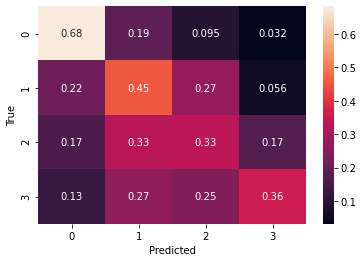

In [44]:
cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [45]:
accuracy_score(test_data['age_group'], label_pred, normalize='true')

0.47642505277973257

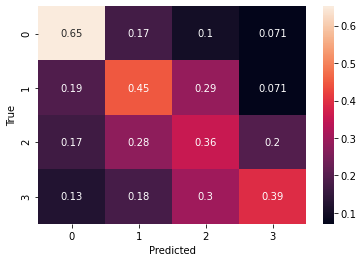

In [46]:
cm = confusion_matrix(test_data['age_group'], label_pred_up, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [47]:
accuracy_score(test_data['age_group'], label_pred_up, normalize='true')

0.476659629368989

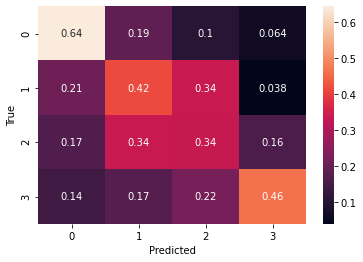

In [48]:
cm = confusion_matrix(test_data['age_group'], label_pred_down, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [49]:
accuracy_score(test_data['age_group'], label_pred_down, normalize='true')

0.46798029556650245

## Emsembling the two models

In [50]:
bert_pred_train = learner.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/train.csv')['text'].values))
bert_pred_val = learner.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/val.csv')['text'].values))

bert_pred_train_up = learner_up.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/train.csv')['text'].values))
bert_pred_val_up = learner_up.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/val.csv')['text'].values))

bert_pred_train_down = learner_down.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/train.csv')['text'].values))
bert_pred_val_down = learner_down.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/val.csv')['text'].values))

05/02/2020 19:15:20 - INFO - root -   Writing example 0 of 15153
05/02/2020 19:15:21 - INFO - root -   Writing example 10000 of 15153
05/02/2020 19:17:54 - INFO - root -   Writing example 0 of 1684
05/02/2020 19:18:11 - INFO - root -   Writing example 0 of 15153
05/02/2020 19:18:12 - INFO - root -   Writing example 10000 of 15153
05/02/2020 19:20:45 - INFO - root -   Writing example 0 of 1684
05/02/2020 19:21:02 - INFO - root -   Writing example 0 of 15153
05/02/2020 19:21:03 - INFO - root -   Writing example 10000 of 15153
05/02/2020 19:23:35 - INFO - root -   Writing example 0 of 1684


In [51]:
meta_pred_train = meta_model.predict_proba(train_data_meta.drop('age_group', axis=1))
meta_pred_val = meta_model.predict_proba(val_data_meta.drop('age_group', axis=1))

meta_pred_train_up = meta_model_up.predict_proba(train_data_meta.drop('age_group', axis=1))
meta_pred_val_up = meta_model_up.predict_proba(val_data_meta.drop('age_group', axis=1))

meta_pred_train_down = meta_model_down.predict_proba(train_data_meta.drop('age_group', axis=1))
meta_pred_val_down = meta_model_down.predict_proba(val_data_meta.drop('age_group', axis=1))

In [52]:
combined_pred_train = []
combined_pred_val = []
count = 0
for pred in bert_pred_train:
    combined_pred_train.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    combined_pred_train[count][0] = meta_pred_train[count][0]
    combined_pred_train[count][1] = meta_pred_train[count][1]
    combined_pred_train[count][2] = meta_pred_train[count][2]
    combined_pred_train[count][3] = meta_pred_train[count][3]
    combined_pred_train[count][4] = meta_pred_train_up[count][0]
    combined_pred_train[count][5] = meta_pred_train_up[count][1]
    combined_pred_train[count][6] = meta_pred_train_up[count][2]
    combined_pred_train[count][7] = meta_pred_train_up[count][3]
    combined_pred_train[count][8] = meta_pred_train_down[count][0]
    combined_pred_train[count][9] = meta_pred_train_down[count][1]
    combined_pred_train[count][10] = meta_pred_train_down[count][2]
    combined_pred_train[count][11] = meta_pred_train_down[count][3]
    for i in range(4):
        if pred[i][0] == 'age_group_0':
            combined_pred_train[count][12] = pred[i][1]
        elif pred[i][0] == 'age_group_1':
            combined_pred_train[count][13] = pred[i][1]
        elif pred[i][0] == 'age_group_2':
            combined_pred_train[count][14] = pred[i][1]
        elif pred[i][0] == 'age_group_3':
            combined_pred_train[count][15] = pred[i][1]
    for i in range(4):
        if bert_pred_train_up[count][i][0] == 'age_group_0':
            combined_pred_train[count][12] = bert_pred_train_up[count][i][1]
        elif bert_pred_train_up[count][i][0] == 'age_group_1':
            combined_pred_train[count][13] = bert_pred_train_up[count][i][1]
        elif bert_pred_train_up[count][i][0] == 'age_group_2':
            combined_pred_train[count][14] = bert_pred_train_up[count][i][1]
        elif bert_pred_train_up[count][i][0] == 'age_group_3':
            combined_pred_train[count][15] = bert_pred_train_up[count][i][1]
    for i in range(4):
        if bert_pred_train_down[count][i][0] == 'age_group_0':
            combined_pred_train[count][12] = bert_pred_train_down[count][i][1]
        elif bert_pred_train_down[count][i][0] == 'age_group_1':
            combined_pred_train[count][13] = bert_pred_train_down[count][i][1]
        elif bert_pred_train_down[count][i][0] == 'age_group_2':
            combined_pred_train[count][14] = bert_pred_train_down[count][i][1]
        elif bert_pred_train_down[count][i][0] == 'age_group_3':
            combined_pred_train[count][15] = bert_pred_train_down[count][i][1]
    count += 1
    
count = 0
for pred in bert_pred_val:
    combined_pred_val.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    combined_pred_val[count][0] = meta_pred_val[count][0]
    combined_pred_val[count][1] = meta_pred_val[count][1]
    combined_pred_val[count][2] = meta_pred_val[count][2]
    combined_pred_val[count][3] = meta_pred_val[count][3]
    combined_pred_val[count][4] = meta_pred_val_up[count][0]
    combined_pred_val[count][5] = meta_pred_val_up[count][1]
    combined_pred_val[count][6] = meta_pred_val_up[count][2]
    combined_pred_val[count][7] = meta_pred_val_up[count][3]
    combined_pred_val[count][8] = meta_pred_val_down[count][0]
    combined_pred_val[count][9] = meta_pred_val_down[count][1]
    combined_pred_val[count][10] = meta_pred_val_down[count][2]
    combined_pred_val[count][11] = meta_pred_val_down[count][3]
    for i in range(4):
        if pred[i][0] == 'age_group_0':
            combined_pred_val[count][12] = pred[i][1]
        elif pred[i][0] == 'age_group_1':
            combined_pred_val[count][13] = pred[i][1]
        elif pred[i][0] == 'age_group_2':
            combined_pred_val[count][14] = pred[i][1]
        elif pred[i][0] == 'age_group_3':
            combined_pred_val[count][15] = pred[i][1]
    for i in range(4):
        if bert_pred_val_up[count][i][0] == 'age_group_0':
            combined_pred_val[count][12] = bert_pred_val_up[count][i][1]
        elif bert_pred_val_up[count][i][0] == 'age_group_1':
            combined_pred_val[count][13] = bert_pred_val_up[count][i][1]
        elif bert_pred_val_up[count][i][0] == 'age_group_2':
            combined_pred_val[count][14] = bert_pred_val_up[count][i][1]
        elif bert_pred_val_up[count][i][0] == 'age_group_3':
            combined_pred_val[count][15] = bert_pred_val_up[count][i][1]
    for i in range(4):
        if bert_pred_val_down[count][i][0] == 'age_group_0':
            combined_pred_val[count][12] = bert_pred_val_down[count][i][1]
        elif bert_pred_val_down[count][i][0] == 'age_group_1':
            combined_pred_val[count][13] = bert_pred_val_down[count][i][1]
        elif bert_pred_val_down[count][i][0] == 'age_group_2':
            combined_pred_val[count][14] = bert_pred_val_down[count][i][1]
        elif bert_pred_val_down[count][i][0] == 'age_group_3':
            combined_pred_val[count][15] = bert_pred_val_down[count][i][1]
    count += 1

In [53]:
ensemble_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

In [54]:
combined_pred_train = pd.DataFrame(combined_pred_train)
combined_pred_val = pd.DataFrame(combined_pred_val)

In [55]:
ensemble_model.fit(combined_pred_train, train_data['age_group'], eval_set=[(combined_pred_val, val_data['age_group'])], early_stopping_rounds=10)

[0]	validation_0-merror:0.00000
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.00000
[2]	validation_0-merror:0.00000
[3]	validation_0-merror:0.00000
[4]	validation_0-merror:0.00000
[5]	validation_0-merror:0.00000
[6]	validation_0-merror:0.00000
[7]	validation_0-merror:0.00000
[8]	validation_0-merror:0.00000
[9]	validation_0-merror:0.00000
[10]	validation_0-merror:0.00000
Stopping. Best iteration:
[0]	validation_0-merror:0.00000



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [56]:
meta_pred = meta_model.predict_proba(test_data_meta.drop('age_group', axis=1))
meta_pred_up = meta_model_up.predict_proba(test_data_meta.drop('age_group', axis=1))
meta_pred_down = meta_model_down.predict_proba(test_data_meta.drop('age_group', axis=1))
combined_pred = []

count = 0
for pred in predictions:
    combined_pred.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    combined_pred[count][0] = meta_pred[count][0]
    combined_pred[count][1] = meta_pred[count][1]
    combined_pred[count][2] = meta_pred[count][2]
    combined_pred[count][3] = meta_pred[count][3]
    combined_pred[count][4] = meta_pred_up[count][0]
    combined_pred[count][5] = meta_pred_up[count][1]
    combined_pred[count][6] = meta_pred_up[count][2]
    combined_pred[count][7] = meta_pred_up[count][3]
    combined_pred[count][8] = meta_pred_down[count][0]
    combined_pred[count][9] = meta_pred_down[count][1]
    combined_pred[count][10] = meta_pred_down[count][2]
    combined_pred[count][11] = meta_pred_down[count][3]
    for i in range(4):
        if pred[i][0] == 'age_group_0':
            combined_pred[count][12] = pred[i][1]
        elif pred[i][0] == 'age_group_1':
            combined_pred[count][13] = pred[i][1]
        elif pred[i][0] == 'age_group_2':
            combined_pred[count][14] = pred[i][1]
        elif pred[i][0] == 'age_group_3':
            combined_pred[count][15] = pred[i][1]
    for i in range(4):
        if predictions_up[count][i][0] == 'age_group_0':
            combined_pred[count][12] = predictions_up[count][i][1]
        elif predictions_up[count][i][0] == 'age_group_1':
            combined_pred[count][13] = predictions_up[count][i][1]
        elif predictions_up[count][i][0] == 'age_group_2':
            combined_pred[count][14] = predictions_up[count][i][1]
        elif predictions_up[count][i][0] == 'age_group_3':
            combined_pred[count][15] = predictions_up[count][i][1]
    for i in range(4):
        if predictions_down[count][i][0] == 'age_group_0':
            combined_pred[count][12] = predictions_down[count][i][1]
        elif predictions_down[count][i][0] == 'age_group_1':
            combined_pred[count][13] = predictions_down[count][i][1]
        elif predictions_down[count][i][0] == 'age_group_2':
            combined_pred[count][14] = predictions_down[count][i][1]
        elif predictions_down[count][i][0] == 'age_group_3':
            combined_pred[count][15] = predictions_down[count][i][1]
    count += 1

In [57]:
label_pred = ensemble_model.predict(pd.DataFrame(combined_pred))

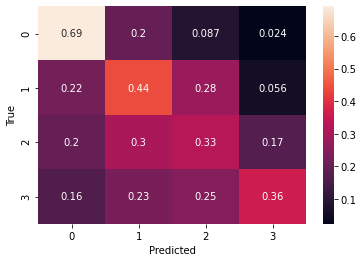

In [58]:
cm = confusion_matrix(test_data['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [59]:
accuracy_score(test_data['age_group'], label_pred, normalize='true')

0.4726718273516303